In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import hierarchical_sampling_model
import hierarchical_model_generator
import util
import smoothing_spline

In [3]:
import allensdk
import h5py
import pynwb
import hdmf
print('pd', pd.__version__)
print('allensdk', allensdk.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)

pd 1.1.1
allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0


## Load samples batches

In [4]:
model = hierarchical_sampling_model.HierarchicalSamplingModel(session=None, empty_samples=True)
model_dir = 'D:/Brain_Network/Output/models/798911424_BSS_MC_0_500ms_probeCDE_condition12_diag_prior_alpha6_20201124-091432/'
model_file = model_dir + '798911424_checkpoints_batch0_20201124-104614.pkl'
model.load_model(model_file)
model_file = model_dir + '798911424_checkpoints_batch7_20201124-203334.pkl'
model.load_model(model_file)

In [5]:
model.samples.peek()

f_pop:0  f_pop_beta:0  q:0  q_shift1:0  q_shift2:0  f_warp_sources:0  f_warp_targets:0  mu_cross_pop:0  sigma_cross_pop:0  rho_cross_pop_simple:0  z:0  p:0  log_likelihood:0  


## Plot results

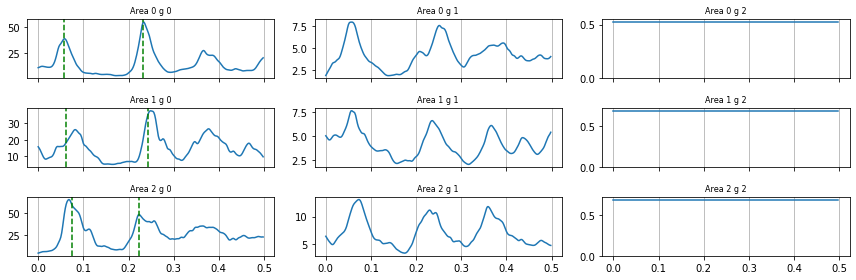

In [9]:
model.plot_f_pop(0)

### True model

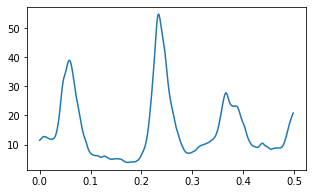

In [10]:
t = model.spike_train_time_line
tms = t * 1000
dt = model.dt
log_f_true = model.f_pop_cag[0,0,0]
f_true = np.exp(log_f_true)

plt.figure(figsize=[5, 3])
plt.plot(t, f_true/dt)
plt.show()

### Generate spikes

(150, 250)


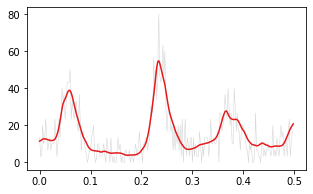

In [228]:
num_trials = 150  # 150
random_seed = 1
generator = hierarchical_model_generator.HierarchicalModelGenerator
np.random.seed(random_seed)
spikes_rt = generator.generate_spike_trains(f_true, num_trials=num_trials, random_seed=random_seed)
print(spikes_rt.shape)

plt.figure(figsize=[5, 3])
plt.plot(t, spikes_rt.mean(axis=0)/dt, c='lightgrey', lw=0.5)
plt.plot(t, f_true/dt)
plt.show()


### Save data

In [393]:
file_path = project_dir + 'Output/simulation/spikes_simulation/spike_trains_for_curve_fitting.mat'
data = spikes_rt
# util.save_as_mat(file_path, data=data, variable_name='data', verbose=True)

Save mat file: D:/Brain_Network/Output/simulation/spikes_simulation/spike_trains_for_curve_fitting.mat


spikes_rt.shape (150, 250)


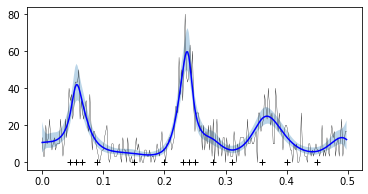

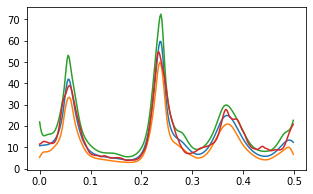

In [38]:
f_fit_spline = model.f_pop_spline_fit_demo(spike_train_time_line=t, spikes_rt=spikes_rt)

plt.figure(figsize=[5, 3])
plt.plot(t, f_fit_spline[0])
plt.plot(t, f_fit_spline[1])
plt.plot(t, f_fit_spline[2])
plt.plot(t, f_true/dt)

spikes_rt.shape (200, 250)
basis shape: (250, 18)
df: 18.000000000000004


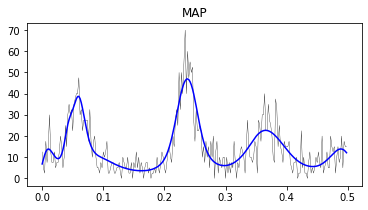

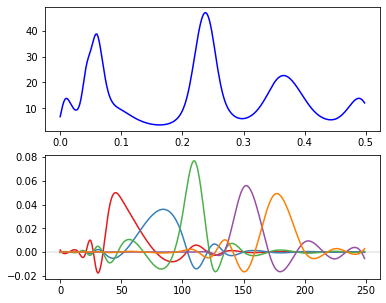

In [166]:
f_fit_sample = model.f_pop_map_fit_demo(spike_train_time_line=t, spikes_rt=spikes_rt, basis='spline', verbose=True)

spikes_rt.shape (150, 250)
basis shape: (250, 102)
IRLS df: 6.587678582673921
Linear df: 15.186430797595445


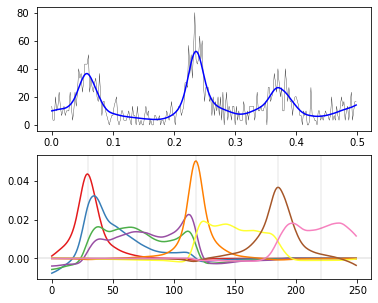

Save figure to:  D:/Brain_Network/Output/fig/smoothing_spline_adaptive_kernel_smoothing.pdf


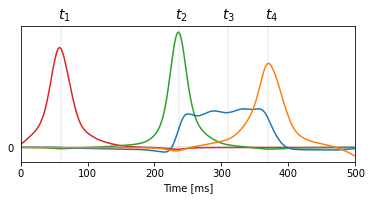

In [288]:
file_path = project_dir + 'Output/fig/smoothing_spline_adaptive_kernel_smoothing.pdf'
f_fit_sample = model.f_pop_map_fit_demo(spike_train_time_line=t, spikes_rt=spikes_rt,
        basis='smoothing', eta_smooth_tuning=4e-8, file_path=file_path, verbose=True)

spikes_rt.shape (150, 250)
basis shape: (250, 102)
spikes.shape (150, 250)
Total iterations: 199
IRLS df: 6.562406626539071
Linear df: 15.186430797595445


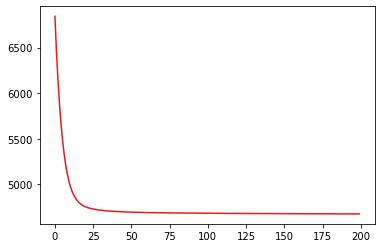

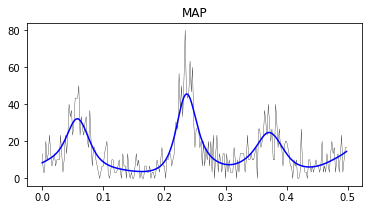

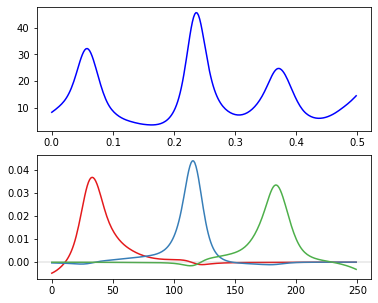

In [239]:
f_fit_sample = model.f_pop_map_logistic_fit_demo(spike_train_time_line=t, spikes_rt=spikes_rt,
        basis='smoothing', eta_smooth_tuning=4e-8, verbose=1)

spikes_rt.shape (200, 250)
basis shape: (250, 102)


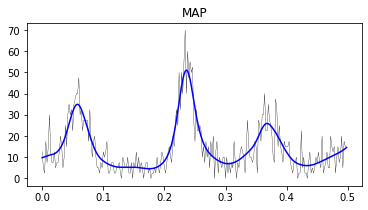

Accept ratio: 0.31325


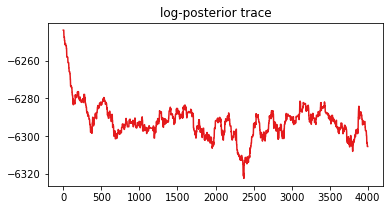

samples len: 2667


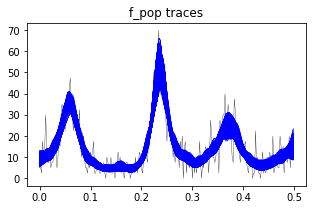

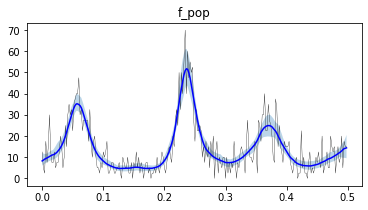

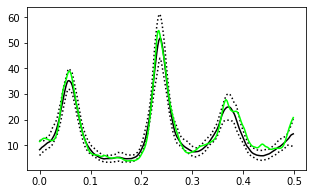

In [165]:
f_fit_sample = model.f_pop_sampling_fit_demo(spike_train_time_line=t, spikes_rt=spikes_rt,
        num_samples=4000, eta_smooth_tuning=5e-8, random_seed=6, verbose=True)

plt.figure(figsize=[5, 3])
plt.plot(t, f_fit_sample[0], 'k')
plt.plot(t, f_fit_sample[1], 'k:')
plt.plot(t, f_fit_sample[2], 'k:')
plt.plot(t, f_true/dt, color='lime')
plt.show()

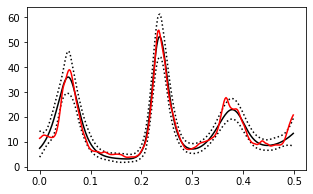

In [20]:
file_path = project_dir + 'Output/simulation/spikes_simulation/BARS_curve_fitting.mat'
data = util.load_as_mat(file_path)

f_fit_bars = [0,0,0]
f_fit_bars[0] = data['fit']['mean'][0,0].reshape(-1)
f_fit_bars[1] = data['fit']['confBands'][0,0][:,0]
f_fit_bars[2] = data['fit']['confBands'][0,0][:,1]

plt.figure(figsize=[5,3])
plt.plot(t, f_fit_bars[0], 'k')
plt.plot(t, f_fit_bars[1], 'k:')
plt.plot(t, f_fit_bars[2], 'k:')
plt.plot(t, f_true/dt, 'r')
plt.show()

### CV for tuning parameter selection.

In [230]:
import smoothing_spline
fit_model = smoothing_spline.SmoothingSpline()

lambda_tuning_list = 10 ** np.arange(-9, -6, 0.1)
print('lambda list:')
print(lambda_tuning_list)

nll_test_array = fit_model.poisson_regression_smoothing_spline_CV(
    spikes_rt, 
    t, 
    n_splits=5,
    lambda_tuning_list=lambda_tuning_list, 
    max_num_iterations=2000,
    verbose=False)

lambda list:
[1.00000000e-09 1.25892541e-09 1.58489319e-09 1.99526231e-09 2.51188643e-09 3.16227766e-09 3.98107171e-09
 5.01187234e-09 6.30957344e-09 7.94328235e-09 1.00000000e-08 1.25892541e-08 1.58489319e-08 1.99526231e-08
 2.51188643e-08 3.16227766e-08 3.98107171e-08 5.01187234e-08 6.30957344e-08 7.94328235e-08 1.00000000e-07
 1.25892541e-07 1.58489319e-07 1.99526231e-07 2.51188643e-07 3.16227766e-07 3.98107171e-07 5.01187234e-07
 6.30957344e-07 7.94328235e-07]


Best lambda: 3.9810717055349207e-08


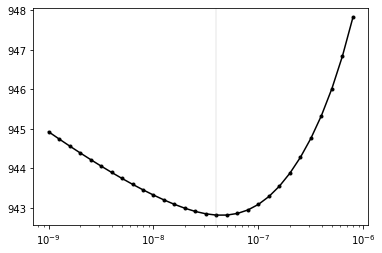

In [231]:
cv_nll_mean = nll_test_array.mean(axis=1)
min_index = np.argmin(cv_nll_mean)
lambda_best = lambda_tuning_list[min_index]
print('Best lambda:', lambda_best)

plt.figure()
plt.plot(lambda_tuning_list, nll_test_array.mean(axis=1), '.-', c='k')
plt.axvline(x=lambda_best, lw=0.2, c='grey')
plt.xscale('log', base=10) 
plt.show()

# Results together.

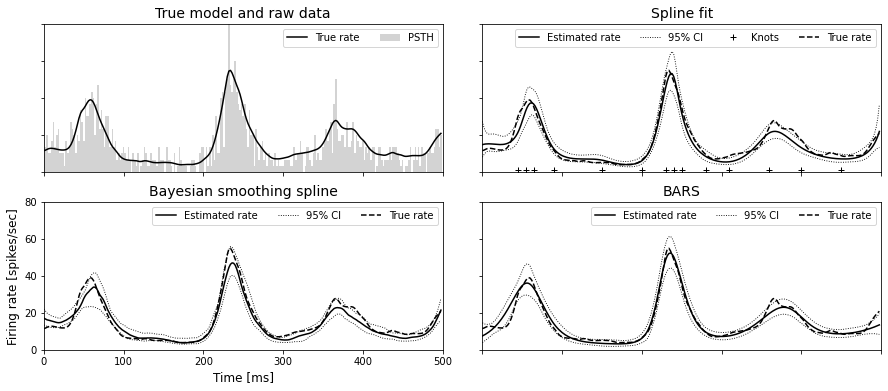

In [21]:
gs_kw = dict(width_ratios=[1, 1], height_ratios=[1, 1])
fig, axs = plt.subplots(figsize=(15, 6), gridspec_kw=gs_kw, nrows=2, ncols=2)
# plt.subplots_adjust(left=None, right=None, top=None, bottom=None, hspace=0.15, wspace=0.3)
plt.subplots_adjust(wspace=0.1)
ax = fig.add_subplot(axs[0, 0])
psth = spikes_rt.mean(axis=0)/dt
# plt.plot(t, , 'k', lw=0.4)
plt.bar(tms, psth, width=2, color='lightgrey', label='PSTH')
plt.plot(tms, f_true / dt, 'k', label='True rate')
plt.legend(loc='upper right', ncol=2)
plt.xlim(0, 500); plt.ylim(0, 80)
plt.title('True model and raw data', fontsize=14)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = fig.add_subplot(axs[0, 1])
plt.plot(tms, f_fit_spline[0], 'k', label='Estimated rate')
plt.plot(tms, f_fit_spline[1], 'k:', lw=0.9, label='95% CI')
plt.plot(tms, f_fit_spline[2], 'k:', lw=0.9)
plt.plot(np.array(f_fit_spline[3])*1000, np.zeros(len(f_fit_spline[3])) + 1, 'k+', label='Knots')
plt.plot(tms, f_true / dt, 'k--', label='True rate')
plt.legend(loc='upper right', ncol=4)
plt.title('Spline fit', fontsize=14)
plt.xlim(0, 500); plt.ylim(0, 80)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = fig.add_subplot(axs[1, 0])
plt.plot(tms, f_fit_sample[0], 'k', label='Estimated rate')
plt.plot(tms, f_fit_sample[1], 'k:', lw=0.9, label='95% CI')
plt.plot(tms, f_fit_sample[2], 'k:', lw=0.9)
plt.plot(tms, f_true / dt, 'k--', label='True rate')
plt.legend(loc='upper right', ncol=3)
plt.title('Bayesian smoothing spline', fontsize=14)
plt.xlim(0, 500); plt.ylim(0, 80)
plt.xlabel('Time [ms]', fontsize=12)
plt.ylabel('Firing rate [spikes/sec]', fontsize=12)


ax = fig.add_subplot(axs[1, 1])
plt.plot(tms, f_fit_bars[0], 'k', label='Estimated rate')
plt.plot(tms, f_fit_bars[1], 'k:', lw=0.9, label='95% CI')
plt.plot(tms, f_fit_bars[2], 'k:', lw=0.9)
plt.plot(tms, f_true / dt, 'k--', label='True rate')
plt.title('BARS', fontsize=14)
plt.legend(loc='upper right', ncol=3)
plt.xlim(0, 500); plt.ylim(0, 80)
ax.set_yticklabels([])
ax.set_xticklabels([])

# output_dir = f'D:/Brain_Network/Output/fig/'
# file_path = os.path.join(output_dir, 'curve_fitting_eg.pdf')
# plt.savefig(file_path, bbox_inches='tight')

plt.show()

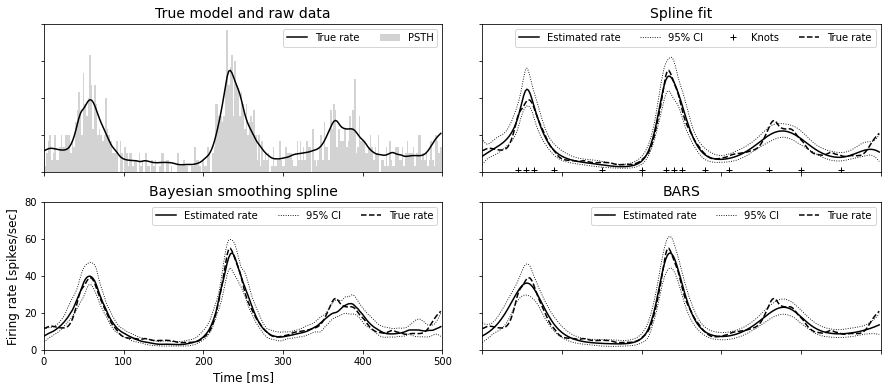

# Smoothing spline test.

(500,) (50, 5000)


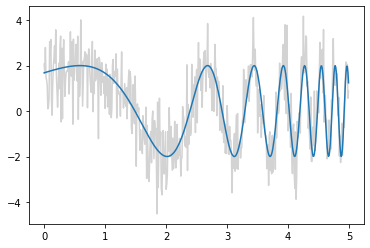

In [52]:
np.random.seed(0)
x = np.arange(0, 5, 0.01)
y_true = np.sin(np.exp(x/1.3)) * 2
y_obs = y_true + np.random.randn(50, len(x))

print(x.shape, y.shape)
plt.plot(x, y_obs[1], c='lightgrey')
plt.plot(x, y_true)


In [ ]:
fit_model = smoothing_spline.SmoothingSpline()
f_fit_sample = fit_model.least_square_regression_smoothing_spline(y, x, lambda_tuning=4e-8, verbose=1)